In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [62]:
# from google.colab import drive
# drive.mount('/content/drive')

In [63]:
#!pip install darts

In [2]:
import warnings

warnings.filterwarnings("ignore")
import logging

logging.disable(logging.CRITICAL)

import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

from darts import concatenate,TimeSeries
from darts.dataprocessing.transformers.scaler import Scaler
from darts.metrics import mae, mse, mql
from darts.models import TiDEModel, TSMixerModel
from darts.utils.likelihood_models import QuantileRegression
from darts.utils.callbacks import TFMProgressBar

In [3]:
tsla_stock_data = pd.read_csv('data/prepared/tsla_feature_data.csv')

In [4]:
tsla_stock_data.tail(5)

,Date,correl,linearreg_angle,ema_low,minus_di,bb_middleband,ultosc,bb_upperband,beta,cci,macdhist,mom,bb_lowerband,adosc,sentscore,return
2637,2024-05-20 13:30:00,0.181112,0.568656,173.932653,2.323501,174.300198,31.200448,174.728215,0.402503,-76.025550,0.024674,0.411499,173.872182,-1.268478e+07,0.00000,0.001504
2638,2024-05-20 14:00:00,0.308363,-0.773613,173.795104,3.442977,174.354959,35.753214,174.700952,0.372684,-96.947627,0.011722,0.163895,174.008966,-9.813551e+06,0.00000,-0.001419
2639,2024-05-20 14:30:00,0.209193,-1.335443,173.916768,3.388051,174.446960,39.697156,174.723835,0.548314,-34.589722,0.020825,0.449997,174.170086,-7.413354e+06,0.00000,0.001642
2640,2024-05-20 15:00:00,0.081021,1.354211,174.091281,3.334100,174.496661,46.735409,174.904565,0.578682,22.851378,0.047840,0.168396,174.088758,-5.160001e+06,0.00000,0.002053
2641,2024-05-20 15:30:00,0.011543,4.611320,174.217521,3.271095,174.640762,50.379821,175.088607,0.651423,44.347506,0.065616,0.098801,174.192917,-2.727263e+06,0.27115,0.000352


In [5]:
tsla_stock_data_ts = TimeSeries.from_dataframe(tsla_stock_data,
                                               time_col='Date',
                                               freq='30min')

In [6]:
tsla_stock_data_ts = tsla_stock_data_ts.astype(np.float32)

In [7]:
tsla_stock_data_ts.columns

Index(['correl', 'linearreg_angle', 'ema_low', 'minus_di', 'bb_middleband',
       'ultosc', 'bb_upperband', 'beta', 'cci', 'macdhist', 'mom',
       'bb_lowerband', 'adosc', 'sentscore', 'return'],
      dtype='object', name='component')

In [8]:
tsla_stock_data_ts_target = tsla_stock_data_ts['return']
tsla_stock_data_ts_past = tsla_stock_data_ts[['correl', 'linearreg_angle', 'ema_low', 'minus_di', 'bb_middleband',
       'ultosc', 'bb_upperband', 'beta', 'cci', 'macdhist', 'mom',
       'bb_lowerband', 'adosc','sentscore']]
#tsla_stock_data_ts_future = tsla_stock_data_ts['sentscore']

In [9]:
# train, val, test = [], [], []
# for trafo in tsla_stock_data_ts_target:
#     train_, temp = tsla_stock_data_ts_target.split_after(0.6)
#     val_, test_ = temp.split_after(0.5)
#     train.append(train_)
#     val.append(val_)
#     test.append(test_)
train, test = tsla_stock_data_ts_target.split_after(0.6)

In [10]:
train.pd_dataframe().tail()

component,return
Date,
2024-04-28 13:00:00,0.0
2024-04-28 13:30:00,0.0
2024-04-28 14:00:00,0.0
2024-04-28 14:30:00,0.0
2024-04-28 15:00:00,0.0


In [11]:
test.pd_dataframe().tail()

component,return
Date,
2024-05-20 13:30:00,0.001504
2024-05-20 14:00:00,-0.001419
2024-05-20 14:30:00,0.001642
2024-05-20 15:00:00,0.002053
2024-05-20 15:30:00,0.000352


In [12]:
scaler = Scaler()  # default uses sklearn's MinMaxScaler
train = scaler.fit_transform(train)
test = scaler.transform(test)
tsla_stock_data_ts_target = scaler.transform(tsla_stock_data_ts_target)

In [13]:
train_past, test_past = tsla_stock_data_ts_past.split_after(0.6)

scaler_past = Scaler()  # default uses sklearn's MinMaxScaler
train_past = scaler_past.fit_transform(train_past)
test_past = scaler_past.fit_transform(test_past)
tsla_stock_data_ts_past = scaler_past.transform(tsla_stock_data_ts_past)

In [14]:
# train_future, train_future = tsla_stock_data_ts_future.split_after(0.6)

# scaler_future = Scaler()  # default uses sklearn's MinMaxScaler
# train_future = scaler_future.fit_transform(train_future)
# tsla_stock_data_ts_future = scaler_future.transform(tsla_stock_data_ts_future)

In [15]:
import optuna
from optuna.integration import PyTorchLightningPruningCallback
from optuna.visualization import (
    plot_optimization_history,
    plot_contour,
    plot_param_importances,
)

In [16]:
def create_params(
    input_chunk_length: int,
    output_chunk_length: int,
    full_training=True,
):
    quantiles = [0.01,0.05,0.1,0.5,0.9,0.95,0.99]
    #quantiles = [0.5,0.6,0.7,0.75,0.8,0.85,0.9,0.95,0.99]
    # early stopping: this setting stops training once the the validation
    # loss has not decreased by more than 1e-5 for 10 epochs
    early_stopper = EarlyStopping(
        monitor="train_loss",
        patience=10,
        min_delta=1e-5,
        mode="min",
    )
    optuna_optimize = PyTorchLightningPruningCallback(100, monitor="train_loss")

    # PyTorch Lightning Trainer arguments (you can add any custom callback)
    if full_training:
        limit_train_batches = None
        limit_val_batches = None
        max_epochs = 200
        batch_size = 256
    else:
        limit_train_batches = None
        limit_val_batches = None
        max_epochs = 200
        batch_size = 256

    # only show the training and prediction progress bars
    progress_bar = TFMProgressBar(
        enable_sanity_check_bar=False, enable_validation_bar=False
    )
    pl_trainer_kwargs = {
        "gradient_clip_val": 1,
        "max_epochs": max_epochs,
        "limit_train_batches": limit_train_batches,
        "limit_val_batches": limit_val_batches,
        "accelerator": "auto",
        "callbacks": [early_stopper, progress_bar],
        #"callbacks": [progress_bar],
        # "accelerator": "gpu",
        # "devices": [0]
    }

    # optimizer setup, uses Adam by default
    optimizer_cls = torch.optim.Adam
    optimizer_kwargs = {
        "lr": 1e-4,
    }

    # learning rate scheduler
    lr_scheduler_cls = torch.optim.lr_scheduler.ExponentialLR
    lr_scheduler_kwargs = {"gamma": 0.999}

    # for probabilistic models, we use quantile regression, and set `loss_fn` to `None`
    likelihood = QuantileRegression(quantiles=quantiles)
    loss_fn = None

    return {
        "input_chunk_length": input_chunk_length,  # lookback window
        "output_chunk_length": output_chunk_length,  # forecast/lookahead window
        "use_reversible_instance_norm": True,
        "optimizer_kwargs": optimizer_kwargs,
        "pl_trainer_kwargs": pl_trainer_kwargs,
        "lr_scheduler_cls": lr_scheduler_cls,
        "lr_scheduler_kwargs": lr_scheduler_kwargs,
        "likelihood": likelihood,  # use a `likelihood` for probabilistic forecasts
        "loss_fn": loss_fn,  # use a `loss_fn` for determinsitic model
        "save_checkpoints": True,  # checkpoint to retrieve the best performing model state,
        "force_reset": True,
        "batch_size": batch_size,
        "random_state": 42,
        "work_dir":'logs/',
        "add_encoders": {
            "cyclic": {
                "future": ["hour", "dayofweek", "month"]
            }  # add cyclic time axis encodings as future covariates
        },
    }

In [17]:
input_chunk_length = 20 * 24
output_chunk_length = 10*24
use_static_covariates = True
full_training = False

In [18]:
model_tsm = TSMixerModel(
    **create_params(
        input_chunk_length,
        output_chunk_length,
        full_training=full_training,
    ),
    use_static_covariates=use_static_covariates,
    model_name="tsm",
    log_tensorboard=True
)

In [19]:
model_tsm.fit(series=tsla_stock_data_ts_target,
              past_covariates=tsla_stock_data_ts_past,
              #future_covariates=tsla_stock_data_ts_future
              )

Epoch 108: 100%|████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00,  8.27it/s, v_num=logs, train_loss=0.0147]


TSMixerModel(output_chunk_shift=0, hidden_size=64, ff_size=64, num_blocks=2, activation=ReLU, dropout=0.1, norm_type=LayerNorm, normalize_before=False, use_static_covariates=True, input_chunk_length=480, output_chunk_length=240, use_reversible_instance_norm=True, optimizer_kwargs={'lr': 0.0001}, pl_trainer_kwargs={'gradient_clip_val': 1, 'max_epochs': 200, 'limit_train_batches': None, 'limit_val_batches': None, 'accelerator': 'auto', 'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x315618450>, <darts.utils.callbacks.TFMProgressBar object at 0x318f48450>]}, lr_scheduler_cls=<class 'torch.optim.lr_scheduler.ExponentialLR'>, lr_scheduler_kwargs={'gamma': 0.999}, likelihood=QuantileRegression(quantiles: Optional[List[float]] = None), loss_fn=None, save_checkpoints=True, force_reset=True, batch_size=256, random_state=42, work_dir=logs/, add_encoders={'cyclic': {'future': ['hour', 'dayofweek', 'month']}}, model_name=tsm, log_tensorboard=True)

In [20]:
pred = model_tsm.predict(n=10*24,
                         past_covariates=tsla_stock_data_ts_past,
                         #future_covariates=tsla_stock_data_ts_future
                         predict_likelihood_parameters=True
                         )

Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.25s/it]


In [21]:
pred_unscaler = scaler.inverse_transform(pred)

In [22]:
pred_unscaler.pd_dataframe()

component,return_q0.01,return_q0.05,return_q0.10,return_q0.50,return_q0.90,return_q0.95,return_q0.99
Date,,,,,,,
2024-05-20 16:00:00,-0.001500,-0.000446,-0.000237,0.000029,0.000251,0.000375,0.001892
2024-05-20 16:30:00,-0.001537,-0.000417,-0.000214,0.000031,0.000242,0.000423,0.001951
2024-05-20 17:00:00,-0.000961,-0.000332,-0.000126,0.000051,0.000209,0.000244,0.001170
2024-05-20 17:30:00,-0.000892,-0.000206,-0.000089,0.000040,0.000167,0.000182,0.001040
2024-05-20 18:00:00,-0.001022,-0.000162,-0.000073,-0.000004,0.000116,0.000181,0.000788
...,...,...,...,...,...,...,...
2024-05-25 13:30:00,-0.004639,-0.002211,-0.001296,-0.000004,0.001334,0.002172,0.005918
2024-05-25 14:00:00,-0.003875,-0.001989,-0.001076,0.000027,0.001049,0.001911,0.005209
2024-05-25 14:30:00,-0.003120,-0.001402,-0.000625,0.000059,0.000573,0.001116,0.004513


In [23]:
# before starting, we define some constants
num_samples = 500

figsize = (10, 6)
lowest_q, low_q, high_q, highest_q = 0.01, 0.1, 0.9, 0.99
label_q_outer = f"{int(lowest_q * 100)}-{int(highest_q * 100)}th percentiles"
label_q_inner = f"{int(low_q * 100)}-{int(high_q * 100)}th percentiles"

In [24]:
from darts.metrics import mape
from datetime import datetime, timedelta

In [25]:
def eval_model(model, forecast_horizon, actual_series):
    pred_series = model.predict(n=forecast_horizon,
                                past_covariates=tsla_stock_data_ts_past,
                                predict_likelihood_parameters=True)
    pred_series = pred_series[['return_q0.90','return_q0.95','return_q0.99']]

    # Rescale data to real value (Inverse transform)
    pred_series = scaler.inverse_transform(pred_series)
    actual_series = scaler.inverse_transform(actual_series)

    # plot actual series
    plt.figure(figsize=figsize)
    end = pred_series.end_time()
    start = end - timedelta(days=30)
    actual_series[start:end].plot(label="actual")

    # plot prediction with quantile ranges
    #pred_series.plot(low_quantile=lowest_q, high_quantile=highest_q, label=label_q_outer)
    pred_series.plot(low_quantile=low_q, high_quantile=high_q, label=label_q_inner)

Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 125.03it/s]


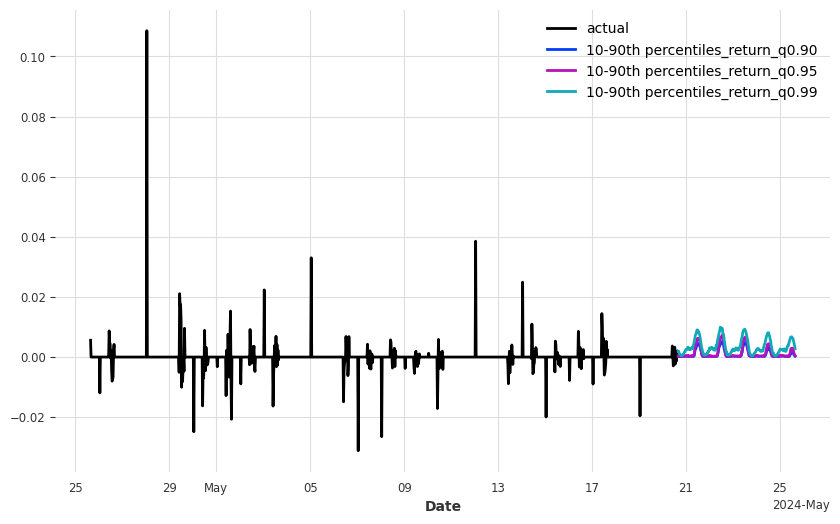

In [26]:
eval_model(model_tsm,240,tsla_stock_data_ts_target)

In [27]:
pred_test = model_tsm.predict(n=10*24,
                              predict_likelihood_parameters=True
                         )

Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 119.76it/s]


In [28]:
pred_test_unscaler = scaler.inverse_transform(pred_test)

In [29]:
pred_test_unscaler.pd_dataframe().resample('1d').mean()

component,return_q0.01,return_q0.05,return_q0.10,return_q0.50,return_q0.90,return_q0.95,return_q0.99
Date,,,,,,,
2024-05-20,-0.002581,-0.000275,-0.000107,0.000037,0.000214,0.000299,0.001182
2024-05-21,-0.005467,-0.001458,-0.001012,0.000026,0.001183,0.001687,0.003764
2024-05-22,-0.006082,-0.001651,-0.001131,0.000039,0.001329,0.001873,0.004053
2024-05-23,-0.005910,-0.001514,-0.001001,0.000060,0.001219,0.001717,0.003739
2024-05-24,-0.005093,-0.001029,-0.000583,0.000057,0.000739,0.001119,0.003196
2024-05-25,-0.005245,-0.000909,-0.000449,0.000046,0.000561,0.000960,0.003833


In [32]:
# Save the model
model_tsm.save('model/tsla_tsm_0520.pkl')

## Evaluation Loss

In [33]:
model_tsm.fit(series=train,
              past_covariates=tsla_stock_data_ts_past,
              #future_covariates=tsla_stock_data_ts_future
              )

Epoch 0: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.10it/s, v_num=logs, train_loss=0.0157]


TSMixerModel(output_chunk_shift=0, hidden_size=64, ff_size=64, num_blocks=2, activation=ReLU, dropout=0.1, norm_type=LayerNorm, normalize_before=False, use_static_covariates=True, input_chunk_length=480, output_chunk_length=240, use_reversible_instance_norm=True, optimizer_kwargs={'lr': 0.0001}, pl_trainer_kwargs={'gradient_clip_val': 1, 'max_epochs': 200, 'limit_train_batches': None, 'limit_val_batches': None, 'accelerator': 'auto', 'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x315618450>, <darts.utils.callbacks.TFMProgressBar object at 0x318f48450>]}, lr_scheduler_cls=<class 'torch.optim.lr_scheduler.ExponentialLR'>, lr_scheduler_kwargs={'gamma': 0.999}, likelihood=QuantileRegression(quantiles: Optional[List[float]] = None), loss_fn=None, save_checkpoints=True, force_reset=True, batch_size=256, random_state=42, work_dir=logs/, add_encoders={'cyclic': {'future': ['hour', 'dayofweek', 'month']}}, model_name=tsm, log_tensorboard=True)

In [34]:
from darts.metrics import mape

In [35]:
# Make predictions
prediction = model_tsm.predict(len(test))

# Evaluate the model
error = mape(test, prediction)
print(f"Mean Absolute Percentage Error (MAPE): {error}")

Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.79s/it]
Mean Absolute Percentage Error (MAPE): 3.913753032684326


## The Information Coefficient (IC)

The Information Coefficient (IC) is a critical metric in evaluating the performance of a financial model, particularly in the context of investment management and stock selection.

**Understand the Information Coefficient (IC)**: The IC measures the correlation between predicted returns (scores) and actual returns (close prices). It ranges from -1 to 1, where 1 indicates perfect positive correlation, -1 indicates perfect negative correlation, and 0 indicates no correlation 

In [36]:
test_sentscore_value = test_past['sentscore'].pd_dataframe().rank()
test_correl_value = test_past['correl'].pd_dataframe().rank() #
test_ema_low_value = test_past['ema_low'].pd_dataframe().rank()
prediction_values = prediction.pd_dataframe()
test_values = prediction.pd_dataframe()

In [40]:
test_sentscore_value['sentscore'].corr(test_values['return'].shift(-1))

0.015660521601661852

In [41]:
test_correl_value['correl'].corr(test_values['return'].shift(-1))

0.06518367719397279

In [42]:
ic = prediction_values['return'].corr(test_values['return'].shift(-1))

In [106]:
print(f'Information Coefficient (IC): {ic}')

Information Coefficient (IC): 0.008373527513929264


## Interpretation
- **Lower MAPE**: Indicates better model accuracy. A MAPE of 0% means perfect predictions.
- **Higher MAPE**: Indicates poorer model accuracy. For instance, a MAPE of 20% means that the average prediction error is 20% of the actual values.

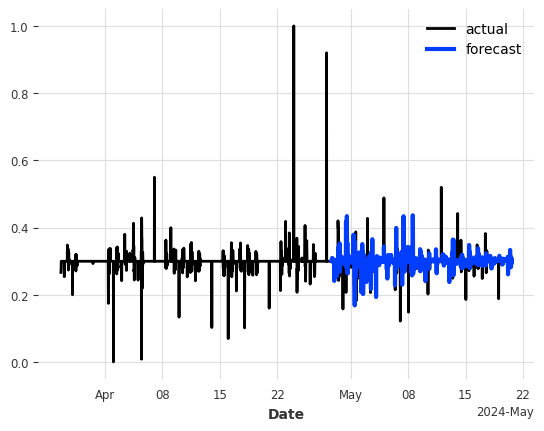

In [43]:
# Plot the results
tsla_stock_data_ts_target.plot(label='actual')
prediction.plot(label='forecast', lw=3)
plt.legend()
plt.show()

# Backtest the probabilistic models

In [44]:
# configure the probabilistic prediction
num_samples = 300
forecast_horizon = output_chunk_length

# compute the Mean Quantile Loss over these quantiles
evaluate_quantiles = [0.01,0.05,0.1,0.5,0.9,0.95,0.99]

In [45]:
def historical_forecasts(model):
    """Generates probabilistic historical forecasts for each transformer
    and returns the inverse transformed results.

    Each forecast covers 5*24h (forecast_horizon). The time between two forecasts
    (stride) is also 5*24 hours.
    """
    returnVal = model.historical_forecasts(
        series=test,
        forecast_horizon=forecast_horizon,
        stride=forecast_horizon,
        last_points_only=False,
        retrain=False,
        #num_samples=num_samples,
        past_covariates=tsla_stock_data_ts_past,
        #future_covariates=tsla_stock_data_ts_future,
        predict_likelihood_parameters=True,
        verbose=True,
    )
    return scaler.inverse_transform(returnVal[0])
    #return scaler.inverse_transform(returnVal)
    #return returnVal

In [46]:
hfcs = historical_forecasts(model_tsm)

Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.20it/s]


<Axes: xlabel='Date'>

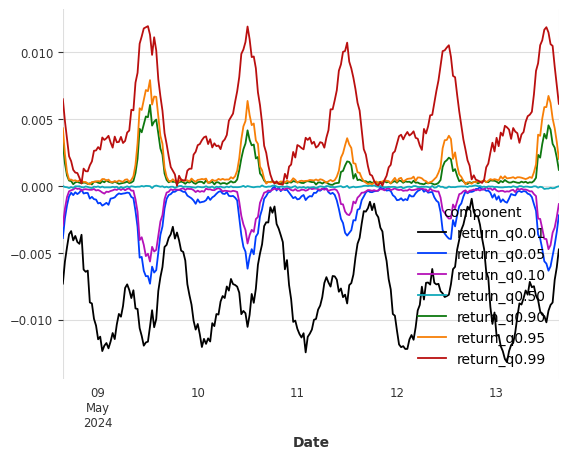

In [47]:
hfcs.pd_dataframe().plot()

In [209]:
# metric_kwargs = [{"q": q} for q in evaluate_quantiles]
# metrics = [mql for _ in range(len(evaluate_quantiles))]
# bt = model_tsm.backtest(series=tsla_stock_data_ts_target,
#                         historical_forecasts=hfcs,
#                         forecast_horizon=forecast_horizon,
#                         stride=forecast_horizon,
#                         retrain=False,
#                         past_covariates=tsla_stock_data_ts_past,
#                         last_points_only=False,
#                         reduction=np.mean,  # this is actually the default,
#                         #metric=metrics,
#                         #metric_kwargs=metric_kwargs,
#                         verbose=True,
#                        )

In [210]:
#print("Average error (MAPE) over all historical forecasts: %.2f" % bt)